In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import re
import json
import transformers

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

# import json
# data_path = "/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json"
# with open(data_path) as file:
#     lines = file.readlines()
#     # print(lines[0])   # str形式的dict

# paper_item = json.loads(lines[0])
# for key, value in paper_item.items():
#     print(key+" : ", value)

# table
id | title | authors |categories | abs | date| ...(citation)|

In [3]:

# papers = []
# for line in lines:
#     papers.append(json.loads(line))
# papers = pd.DataFrame(papers)
# papers = papers.drop(columns=["comments","journal-ref","doi","report-no", "license"])
# papers.head()

In [4]:

# len(papers)   # 2370685
# import re
# pattern = r"(^|\s)cs\."  # 匹配 "由cs.开头或\space cs. "的模式
# matches = papers["categories"].str.match(pattern, na=False)

# cs_papers = papers[matches]  # len() 462764
# cs_papers["categories"].unique()

In [5]:
# cs_papers_path = "/kaggle/working/cs_papers.json"
# if not os.path.exists(cs_papers_path):
#     cs_papers.to_json(cs_papers_path)

## 考虑利用title和categories训练一个多分类器

### TF-IDF 表示标题特征
(462764, 101910)
TF-IDF生成的矩阵维数太高了，不太行。。。
> 后期可以考虑tokenizer + embbeding 表示为向量

数据分布不太平均，只含1个label的paper含2个label的paper数量的两倍，是含3个label的paper的数量的5倍。
### 训练一个多分类器

In [6]:

# # 需要去除categories中非cs的标签
# # 首先将categories 字符串分割，只保留cs标签
# # 构建 (id) tittle : ["cs.label1", "cs.label2"]
# cs_papers_path = "/kaggle/working/cs_papers.json"
# if cs_papers is None:
#     with open(cs_papers_path, "r") as f:
#         cs_papers = pd.DataFrame(json.load(f))
        
# for index, row in cs_papers.iterrows():
#     words = row["categories"].split()
#     processed_words = [word for word in words if word.startswith('cs.')]
    
#     cs_papers.at[index, "categories"] = processed_words

# cs_papers.head()

In [7]:

# title_categories = cs_papers[["title", "categories"]]
# title_categories.head()


In [8]:

# title_abs_categories = cs_papers[["title", "abstract","categories"]]
# title_abs_categories.head()

In [9]:

# title_categories_path = "/kaggle/working/title_categories.json"
# title_abs_categories_path = "/kaggle/working/title_abs_categories.json"
# if not os.path.exists(title_abs_categories_path):
#     title_abs_categories.to_json(title_abs_categories_path)
# if not os.path.exists(title_categories_path):
#     title_categories.to_json(title_categories_path)

# 从这里开始title-categories的分类

In [10]:
title_categories_path = "/kaggle/input/mydatasets/title_categories.json"

with open(title_categories_path, "r") as f:
    title_categories = pd.DataFrame(json.load(f))
title_categories.head()

,title,categories
46,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]"
49,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]"
61,On-line Viterbi Algorithm and Its Relationship...,[cs.DS]
89,Real Options for Project Schedules (ROPS),"[cs.CE, cs.MS, cs.NA]"
97,Sparsely-spread CDMA - a statistical mechanics...,[cs.IT]


{2: 136602, 1: 276364, 3: 40881, 4: 7712, 5: 1174, 7: 3, 6: 28}


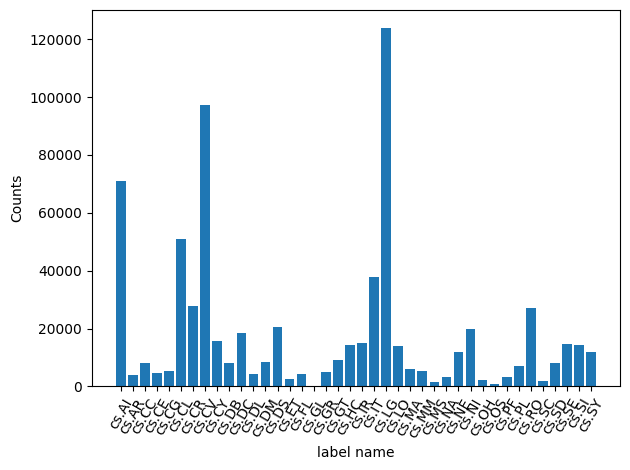

In [11]:
labels_counts = {}
multi_label_counts = {}
for labels in title_categories["categories"]:
    multi_label_counts[len(labels)] = multi_label_counts.get(len(labels), 0) + 1
    for label in labels:
        labels_counts[label] = labels_counts.get(label, 0) + 1

print(multi_label_counts)
label_set = sorted(labels_counts.keys())
# 40 类
plt.bar(label_set, [labels_counts[key] for key in label_set])
plt.xticks(rotation=60)
plt.xlabel("label name")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()


## multi_label_counts：
- num_labels : counts
- 1 :  276364
- 2 :  136602
- 3 :  40881
- 4 :  7712
- 5 :  1174
- 6 :  28
- 7 :  3

绝大多数的paper的label个数在5个以内，大多数在3个以内。

In [12]:
max_length = 0
for title in title_categories["title"]:
    length = len(title.split())
    if length > max_length:
        max_length = length
max_length   # 37

37

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
multilabels = MultiLabelBinarizer()
# 转换成k-hot形式的multi-labels
y_multilabels = multilabels.fit_transform(title_categories["categories"].values)
print(y_multilabels.shape)    #(462764, 40)
print(y_multilabels[:5])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(462764, 40)
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
  0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]


In [14]:
# Load model directly
from transformers import BertModel,BertTokenizer
bert_model = BertModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
tokenizer = BertTokenizer.from_pretrained("google/bert_uncased_L-2_H-128_A-2")

In [15]:
out = tokenizer.batch_encode_plus(title_categories["title"].to_list(), max_length=48,
                                  padding="max_length", truncation=True)
print(out.keys())
input_ids = np.array(out['input_ids'])
attention_masks = np.array(out['attention_mask'])


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [16]:
class MyDataSet(Dataset):
    def __init__(self, X, masks, y) -> None:
        super().__init__()
        self.X = torch.from_numpy(X).int()
        self.masks = torch.from_numpy(masks).int()
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index], self.masks[index], self.y[index]

In [17]:
class MyClassifier(nn.Module):
    def __init__(self, num_hidden, num_class):
        super().__init__()
        self.bert = bert_model    # 作为embedding层，进行fine-tuning
        for param in self.bert.parameters():
            param.requires_grad = True
        
        # k cnn-filters k(out_channels)->32
        # 试了一下(16, 32, 48) 32的效果最好
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 128)) # out= in - kernel_size + 1
        self.conv2 = nn.Conv2d(1, 32, kernel_size=(5, 128))
        self.conv3 = nn.Conv2d(1, 32, kernel_size=(7, 128))
        # N,C_out,
        self.pooling = nn.MaxPool2d((3,1), (3,1))
        self.fc1 = nn.Linear(32*44, num_hidden)
        self.sig1 = nn.Sigmoid()
        self.fc2 = nn.Linear(num_hidden, num_class)
        #self.sig2 = nn.Sigmoid()
  
    def forward(self, x, mask):
        # 取bert最后一层隐状态
        out = self.bert(x, attention_mask=mask, token_type_ids=None,)
        last_hidden_state = out["last_hidden_state"]  # N, 48, 128
        #print(hidden_states.shape)
        last_hidden_state.unsqueeze_(1)  # N, 1, 48, 128
        
        out1 = self.conv1(last_hidden_state)  # 48 - 3 + 1
        out2 = self.conv2(last_hidden_state)
        out3 = self.conv3(last_hidden_state)
        out = torch.cat([out1, out2, out3], dim=2)  # N, 32, (46 + 44 + 42 = 132), 1
        out = self.pooling(out)  # N, 32, 44, 1
        #print(out.shape)
        out = out.reshape(out.shape[0], -1)
        #print(out.shape)
        out = self.sig1(self.fc1(out))
        out = self.fc2(out)
        
        #print(out.shape)
        return out
        

In [18]:
test_radio = 0.2
batch_size = 128
# [:25600]
X_train, X_val, mask_train, mask_val, y_train, y_val = train_test_split(input_ids, attention_masks, y_multilabels, test_size=test_radio, random_state=49)
train_dataset, val_dataset = MyDataSet(X_train, mask_train, y_train), MyDataSet(X_val, mask_val, y_val)
train_loader, val_loader = DataLoader(train_dataset, batch_size, shuffle=True), DataLoader(val_dataset, batch_size*5)

In [19]:
from transformers import get_scheduler
model = MyClassifier(num_hidden=512 ,num_class=40)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.AdamW(model.parameters(), lr=1e-4) #fine-tuning bert
criterion = nn.BCEWithLogitsLoss()
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, 
    num_training_steps=num_training_steps)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

MyClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine

In [20]:
def adapter_precision(predicts, labels):
    predicts, labels = predicts.to(device), labels.to(device)
    precision = 0.0
    for i in range(labels.shape[0]):
        labels_num, label_ids = torch.sum(labels[i]).item(), torch.nonzero(labels[i]).squeeze()
        # 根据实际label数，选择predict中预测topk
        _, pred_ids = predicts[i].topk(int(labels_num))
        # 计算两组下标相同元素的数目，从而获得precision，并累加
        precision += torch.sum(torch.isin(pred_ids, label_ids)).item() / labels_num
    return precision / labels.shape[0]

def precision_k(predicts, labels, k=3):
    """
    predicts : (batch_size, C)
    labels : (batch_size, C)  {0, 1}^C
    """
    predicts, labels = predicts.to(device), labels.to(device)
    _, topk_pred_ids = predicts.topk(k, dim=1)  # batch_size, k

    precision_rank_k = torch.zeros(labels.shape[0]).to(device) # batch_size,
    
    for pred_ids in topk_pred_ids.T:
        precision_rank_k += labels[torch.arange(labels.shape[0]), pred_ids]
        
    return precision_rank_k / k

def topk_eval(net, top_k:list, val_loader, metric=precision_k):
    net.eval()
    correct_topk = torch.zeros(len(top_k))
    with torch.no_grad():
        for x, mask, y in val_loader:
            x, mask = x.to(device), mask.to(device)
            outputs = net(x, mask)
            for i, k in enumerate(top_k):
                correct_topk[i] += metric(outputs, y, k).mean().item()
    
    return correct_topk / len(val_loader)

def actual_eval(net, val_loader, metric):
    net.eval()
    correct = 0.0
    with torch.no_grad():
        for x, mask, y in val_loader:
            x, mask = x.to(device), mask.to(device)
            outputs = net(x, mask)
            correct += metric(outputs, y)
                   
    return correct / len(val_loader)
    

In [21]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

top_k = [1, 2, 3]
actual = True
log_num = 1
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for x, mask, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x.to(device), mask.to(device))
        loss = criterion(outputs.to(device), y.to(device))
        #with torch.autograd.set_detect_anomaly(True):
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        lr_scheduler.step()
        
        progress_bar.update(1)
    if (epoch + 1)% log_num == 0:
        print(f"[Train]: {epoch + 1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")
    
        precisions = topk_eval(model, top_k, val_loader=val_loader)
        for i, k in enumerate(top_k):    
            print(f"P@{k}={precisions[i].item()*100:.4f}%")
        if actual:   # 根据实际label数目计算的precision
            actual_precison = actual_eval(model, val_loader, metric=adapter_precision)
            print(f"adapted_P={actual_precison*100:.4f}%")



  0%|          | 0/28930 [00:00<?, ?it/s]

[Train]: 1/10, Loss: 0.12198583906110166
P@1=67.7308%
P@2=47.4512%
P@3=37.0246%
adapted_P=61.1973%
[Train]: 2/10, Loss: 0.0776414924693631
P@1=73.2099%
P@2=51.3144%
P@3=39.6048%
adapted_P=66.8351%
[Train]: 3/10, Loss: 0.07081927945261136
P@1=75.0240%
P@2=52.5683%
P@3=40.4563%
adapted_P=68.6756%
[Train]: 4/10, Loss: 0.06751118891901761
P@1=75.7316%
P@2=53.0214%
P@3=40.7900%
adapted_P=69.5142%
[Train]: 5/10, Loss: 0.06532559388037416
P@1=76.2146%
P@2=53.3168%
P@3=41.0063%
adapted_P=69.9007%
[Train]: 6/10, Loss: 0.06372420475108377
P@1=76.5505%
P@2=53.4678%
P@3=41.0788%
adapted_P=70.2493%
[Train]: 7/10, Loss: 0.062486458242691556
P@1=76.6459%
P@2=53.5465%
P@3=41.1194%
adapted_P=70.3637%
[Train]: 8/10, Loss: 0.06158516035539816
P@1=76.7514%
P@2=53.6229%
P@3=41.2230%
adapted_P=70.4939%
[Train]: 9/10, Loss: 0.0608487129752256
P@1=76.7230%
P@2=53.6799%
P@3=41.2147%
adapted_P=70.5625%
[Train]: 10/10, Loss: 0.06037559488004687
P@1=76.7934%
P@2=53.7130%
P@3=41.2412%
adapted_P=70.6117%


In [22]:
def predict_categories(model, titles:list[str], label_set=label_set, tokenizer=tokenizer):
    num_papers = len(titles)
    pred_categories = {}
    model.cpu()
    model.eval()
    out = tokenizer.batch_encode_plus(titles, max_length=48,
                                  padding="max_length", truncation=True)
    token_ids, attn_masks = out["input_ids"], out["attention_mask"]
    # 转为tensor，
    token_ids = torch.tensor(token_ids).int()
    attn_masks = torch.tensor(attn_masks).int()

    with torch.no_grad():
        for i in range(num_papers):
            # 添加batch_size维度
            x, mask = token_ids[i].unsqueeze_(0), attn_masks[i].unsqueeze_(0)
            output = model(x, mask)
            # 获取top3的标签
            _, pred_ids = output.topk(k=3)
            
            pred_categories[titles[i]] = [label_set[ids.item()] for ids in pred_ids.squeeze(0)]

    return pred_categories

In [23]:
with open("/kaggle/input/mydatasets/test_t_c.json") as f:
    test_t_c = json.load(f)
    
test_t_c = pd.DataFrame([[k, v] for k, v in test_t_c.items()], columns=["title", "categories"])
    
for index, row in test_t_c.iterrows():
    words = row["categories"]
    processed_words = [word for word in words if word.startswith('cs.')]
    
    test_t_c.at[index, "categories"] = processed_words
test_t_c.head(10)

,title,categories
0,Mathematical Logic in Computer Science,[cs.LO]
1,Ten Research Challenge Areas in Data Science,"[cs.CY, cs.AI]"
2,Why The Trans Programmer?,[cs.CY]
3,Defining Data Science,"[cs.DB, cs.CY]"
4,Proceedings 11th Doctoral Workshop on Mathemat...,"[cs.LO, cs.DS, cs.SE]"
5,FAIR and Open Computer Science Research Software,[cs.SE]
6,A Polynomial Translation of pi-calculus FCPs t...,[cs.LO]
7,A computational medical XR discipline,"[cs.GR, cs.HC]"
8,Computer Science,[cs.CY]
9,Decidability of higher-order matching,"[cs.LO, cs.GT]"


In [24]:
test_titles = test_t_c["title"].to_list()[:10]
# test_titles = ["LayerCollapse: Adaptive compression of neural networks"]
pred_categories = predict_categories(model, titles=test_titles, label_set=label_set, tokenizer=tokenizer)
for k, v in pred_categories.items():
    print(k, ": ", v)

Mathematical Logic in Computer Science :  ['cs.LO', 'cs.AI', 'cs.CC']
Ten Research Challenge Areas in Data Science :  ['cs.DL', 'cs.CY', 'cs.DB']
Why The Trans Programmer? :  ['cs.PL', 'cs.HC', 'cs.AI']
Defining Data Science :  ['cs.DB', 'cs.DL', 'cs.CY']
Proceedings 11th Doctoral Workshop on Mathematical and Engineering Methods in Computer Science :  ['cs.LO', 'cs.MS', 'cs.CE']
FAIR and Open Computer Science Research Software :  ['cs.CY', 'cs.DL', 'cs.SE']
A Polynomial Translation of pi-calculus FCPs to Safe Petri Nets :  ['cs.LO', 'cs.FL', 'cs.SC']
A computational medical XR discipline :  ['cs.HC', 'cs.AI', 'cs.CY']
Computer Science :  ['cs.CY', 'cs.DL', 'cs.OH']
Decidability of higher-order matching :  ['cs.LO', 'cs.FL', 'cs.PL']
